k/kcrit = 0.022222222222222223


<ipython-input-23-d558283bcb51>:111: RuntimeWarning: divide by zero encountered in log10
  plt.plot(h_t_yrs[1:], np.log10(h_V))


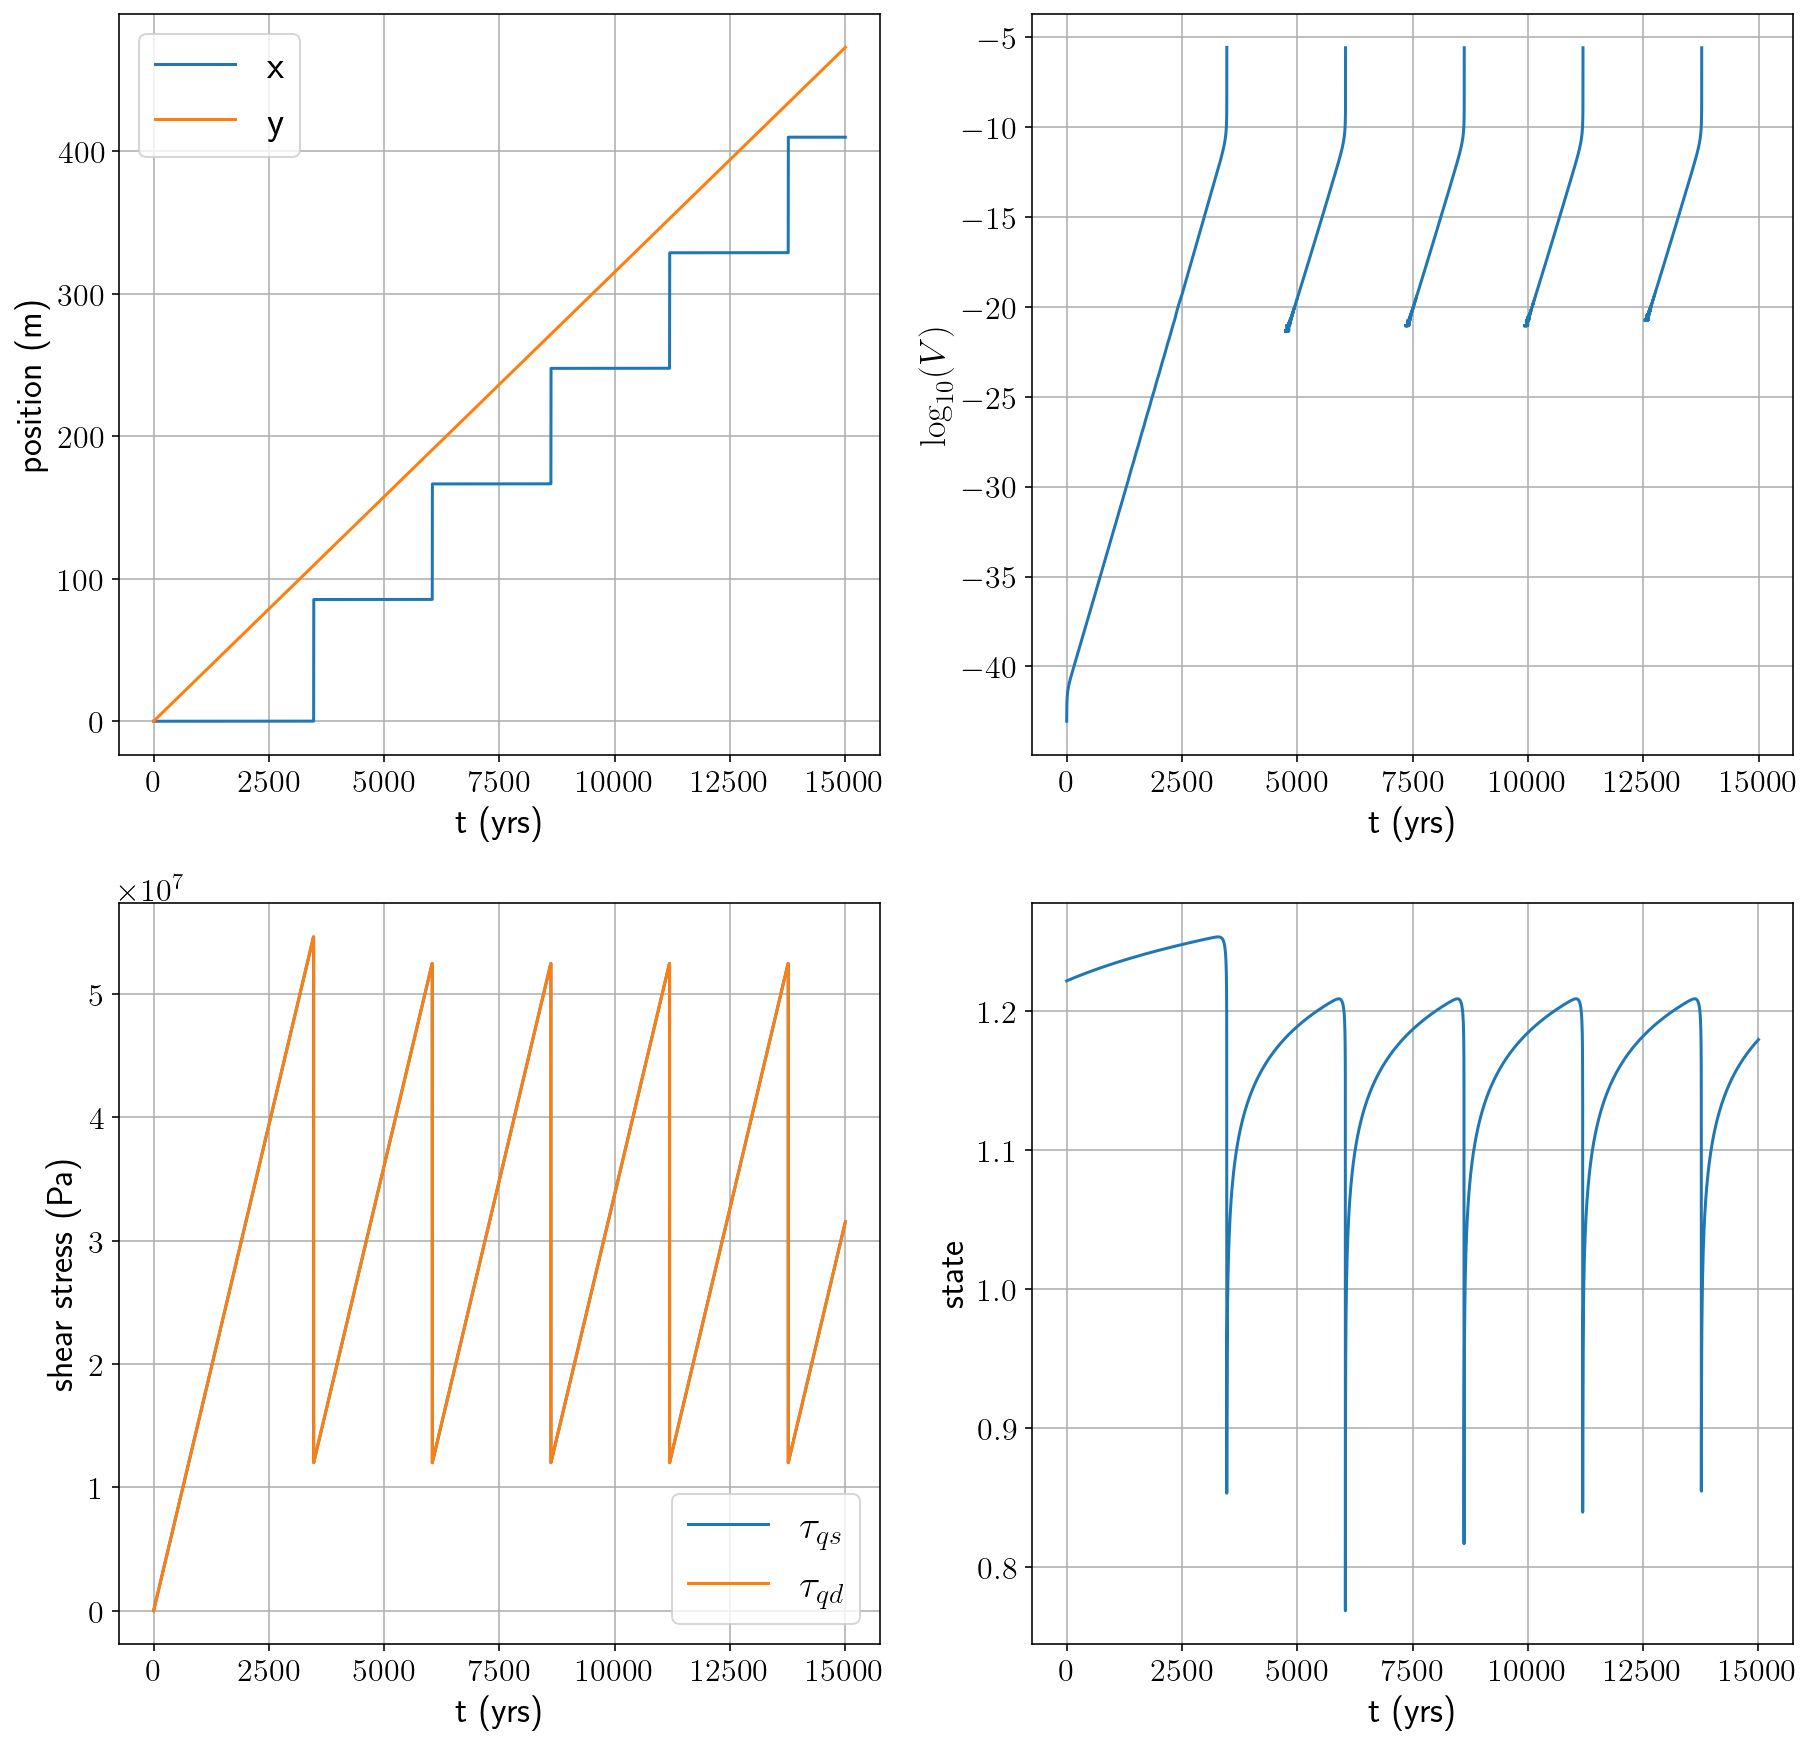

In [23]:
###https://tbenthompson.com/post/block_slider/

import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import ode, odeint
import matplotlib.pyplot as plt

sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # The radiation damping coefficient (kg / (m^2 * s))
L = 60 * 1000              # Width of our plate boundary (m)
k = sm / L                 # spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion

sigma_n = 50e6   # Normal stress (Pa)

## Three parameters to vary
a = 0.015        # direct velocity strengthening effect
b = 0.045         # state-based velocity weakening effect
f0 = 0.6         # baseline coefficient of friction
####

Dc = 0.1         # state evolution length scale (m)
V0 = 1e-6        # when V = V0, f = f0, V is (m/s)

# Rate-state friction law w/ Rice et al 2001 regularization so that 
# it is nonsingular at V = 0
def F(V, sigma_n, state):
    f = a * np.arcsinh(V / (2 * V0) * np.exp(state / a))
    # the frictional stress is equal to the friction coefficient * the normal stress.
    return f * sigma_n

# State evolution law -- aging law.
def G(V, state):
    return (b * V0 / Dc) * (np.exp((f0 - state) / b) - (V / V0))

kcrit = sigma_n * b / Dc 
print('k/kcrit =', k / kcrit)   ## k > k_{crit} is unconditionally unstable

x_0 = 0.0 # slider position
V_slider_0 = Vp / 1000.0 # Initially, the slider is moving at 1/1000th the plate rate.

def steady_state(V_slider):
    def f(state):
        return G(V_slider, state)
    return fsolve(f, 0.0)[0]
state_0 = steady_state(V_slider_0)

def current_vel(tau_qs, state, V_slider_old):
    def f(V):
        return tau_qs - eta * V - F(V, sigma_n, state)
    return fsolve(f, V_slider_old)[0]

secs_per_year = 365 * 24 * 60 * 60
h_t_yrs = np.linspace(0.0, 15000.0, 15001)
h_t = h_t_yrs * secs_per_year

def f(x_and_state, t):
    x, state = x_and_state
    # The position of the load point.
    y = Vp * t 
    
    # The extensional force of our spring 
    tau_qs = k * (y - x) 
    
    # Solve for the current velocity
    V_slider = current_vel(tau_qs, state, f.V_slider_old) 
    
    # Store the velocity to use it next time for warm-start the velocity solver
    f.V_slider_old = V_slider 
    
    dxdt = V_slider
    dstatedt = G(V_slider, state)
    return [dxdt, dstatedt]
f.V_slider_old = V_slider_0

initial_conditions = np.array([x_0, state_0])

history = odeint(f, initial_conditions, h_t, rtol=1e-12, atol=1e-12, mxstep=5000)
h_x = history[:,0]
h_state = history[:,1]
h_V = (h_x[1:] - h_x[:-1]) / (h_t[1:] - h_t[:-1])
h_y = h_t * Vp
h_tau_qs = k * (h_y - h_x)
h_tau_qd = h_tau_qs[1:] - eta * h_V

#plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'
plt.rcParams['savefig.transparent'] = False
plt.figure(figsize = (15, 15))
ax11 = plt.subplot(221)
plt.plot(h_t_yrs, h_x, label = 'x')
plt.plot(h_t_yrs, h_y, label = 'y')
plt.xlabel('t (yrs)')
plt.ylabel('position (m)')
plt.grid()
plt.legend()
ax12 = plt.subplot(222)
plt.plot(h_t_yrs[1:], np.log10(h_V))
plt.xlabel('t (yrs)')
plt.ylabel('$\\log_{10}(V)$')
plt.grid()
plt.subplot(223, sharex = ax11)
plt.plot(h_t_yrs, h_tau_qs, label = '$\\tau_{qs}$')
plt.plot(h_t_yrs[1:], h_tau_qd, label = '$\\tau_{qd}$')
plt.xlabel('t (yrs)')
plt.ylabel('shear stress (Pa)')
plt.grid()
plt.legend()
plt.subplot(224)
plt.plot(h_t_yrs, h_state)
plt.xlabel('t (yrs)')
plt.ylabel('state')
plt.grid()
plt.savefig('qd_1d.pdf', bbox_inches = 'tight')
plt.savefig('qd_1d.png', bbox_inches = 'tight', dpi = 200)
plt.show()